In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#matplotlib inline

# load the dataset
penguins = pd.read_csv('./penguins_size.csv')

# take a look at the various features of the dataset
print(f"Shape of data: {penguins.shape}")
penguins.head()

# we want to classify penguin species, so 'species' will be our target
# we have 6 features 

Shape of data: (344, 7)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [2]:
# DATA EXPLORATION and PREPARATION

penguins['species'].unique() # we have 3 unique species names to classify: 'Adelie', 'Chinstrap', 'Gentoo'

penguin_classes = ['Adelie', 'Chinstrap', 'Gentoo']

# we have some null values to get rid of
penguins = penguins.dropna()

# DATASET IS SMALL SO MIGHT WANT TO OVERSAMPLE IT TO INCREASE ITS SIZE
for i in range(1,3):
    penguins = penguins.append(penguins)

# let's encode the labels with their own binary classification column so as to avoid any fictitious scaling
# of the target. 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

# transform all categorical features, asigning new binary columns for each category so as to avoid 
# erroneous feature scaling
ct = ColumnTransformer([("island", OneHotEncoder(),['island']),("species", OneHotEncoder(),['species']),\
                       ("sex", OneHotEncoder(),['sex'])],remainder="passthrough")
penguins_transformed=ct.fit_transform(penguins) # data is now in array form  

# let's also put the transformed data in to a dataframe to visiually check everything is working properly
# ColumnTransformer has a nice attribute get_feature_names() to track the way it orders the transformed column
transformed_columns=ct.get_feature_names()
penguins_transformed_df=pd.DataFrame(penguins_transformed,columns=transformed_columns) 

# for the same reason, we also need to extract the list of penguin classes for use later, when validating results 
# and producing predictions with class labels. As it happens, CT has retained the original ordering of these 
# categories, probably because they just so happen to have been ordered alphabetically already. 
# But for reliability we'll make sure here
penguin_classes=transformed_columns[3:6]
for i in range(len(penguin_classes)):
    penguin_classes[i]=penguin_classes[i][12:]

In [3]:
from sklearn.model_selection import train_test_split

# before scaling, let's split the data first to avoid information leakage. y's defined above
X=penguins_transformed_df.drop(columns=['species__x0_Adelie','species__x0_Chinstrap',\
                                      'species__x0_Gentoo','sex__x0_.']) # features
y=penguins_transformed_df[['species__x0_Adelie','species__x0_Chinstrap','species__x0_Gentoo']] # labels

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)

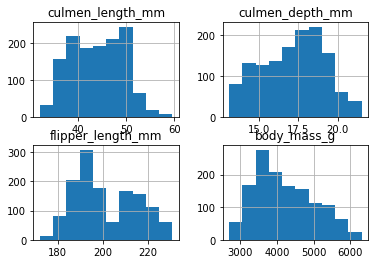

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# we can now re-scale the remaining non-categorical features to avoid unequal weighting in the ML algorithms

penguins.hist() # first let's look at the distributions of each feature
# each feature follows a non-Gaussian distribution so we'll normalise our data instead of standardising
# at least for a first pass. However, we'll compare performance results on raw, normalised and standardised for ref. 

# need dataframe copies for normalisation and standardisation scalin
X_train_norm=X_train.copy()
X_test_norm=X_test.copy()
X_train_scale=X_train.copy()
X_test_scale=X_test.copy()

# fit scaler on non-categorical training data
norm = MinMaxScaler().fit(X_train[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
# transform training data
X_train_norm_noncat = norm.transform(X_train[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
# transform testing dataa
X_test_norm_noncat = norm.transform(X_test[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
# need to recombine scaled data with categorical data
# we only actually need to use the copied datasets here when recombining as the above df slices didnt
# affect the dfs themselves
X_train_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_train_norm_noncat
X_test_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_test_norm_noncat

# let's also standardise our data for comparison
scale = StandardScaler().fit(X_train[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
X_train_scale_noncat = scale.transform(X_train[['culmen_length_mm','culmen_depth_mm',\
                                                'flipper_length_mm','body_mass_g']])
X_test_scale_noncat = scale.transform(X_test[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
X_train_scale[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_train_scale_noncat
X_test_scale[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_test_scale_noncat

In [5]:
# our data is preprocessed and ready to be used to train some models
# we'll begin with a neural network

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# Set random seed for reproducability
tensorflow.random.set_seed(0)

In [6]:
hl = 10 # Number of hidden layer nodes

num_features=X_train.shape[1]
num_penguin_classes=y_train.shape[1]

model_norm = Sequential()
model_norm.add(Dense(hl, input_dim=num_features, activation='relu'))
model_norm.add(Dense(hl, input_dim=hl, activation='relu'))
model_norm.add(Dense(num_penguin_classes, input_dim=hl, activation='softmax'))

print(model_norm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________
None


2022-04-05 14:24:16.498388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#hyper-parameters for optimizer
learning_rate = 0.001
opt = optimizers.Adam(learning_rate=learning_rate)

model_norm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
# Train the model over 50 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 50
history = model_norm.fit(X_train_norm, y_train, epochs=num_epochs, batch_size=10, validation_data=(X_test_norm, y_test))

2022-04-05 14:24:24.794959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
107/107 [==============================] - 0s 2ms/step - loss: 0.9835 - accuracy: 0.5075 - val_loss: 0.8490 - val_accuracy: 0.5522
Epoch 2/50
107/107 [==============================] - 0s 711us/step - loss: 0.7364 - accuracy: 0.7041 - val_loss: 0.6108 - val_accuracy: 0.7351
Epoch 3/50
107/107 [==============================] - 0s 676us/step - loss: 0.5041 - accuracy: 0.8006 - val_loss: 0.3866 - val_accuracy: 0.8433
Epoch 4/50
107/107 [==============================] - 0s 715us/step - loss: 0.3302 - accuracy: 0.9176 - val_loss: 0.2526 - val_accuracy: 0.9515
Epoch 5/50
107/107 [==============================] - 0s 694us/step - loss: 0.2277 - accuracy: 0.9551 - val_loss: 0.1801 - val_accuracy: 0.9627
Epoch 6/50
107/107 [==============================] - 0s 709us/step - loss: 0.1588 - accuracy: 0.9738 - val_loss: 0.1226 - val_accuracy: 0.9813
Epoch 7/50
107/107 [==============================] - 0s 717us/step - loss: 0.1170 - accuracy: 0.9803 - val_loss: 0.0934 - val_accuracy: 0

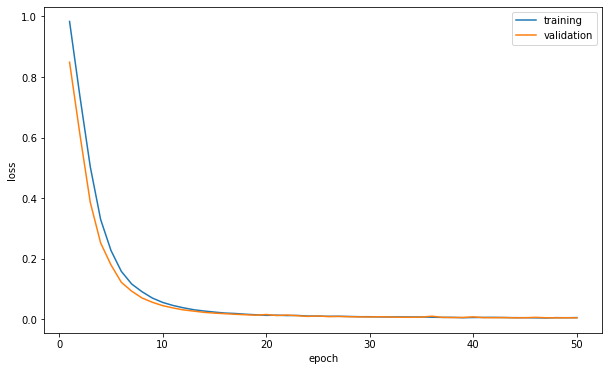

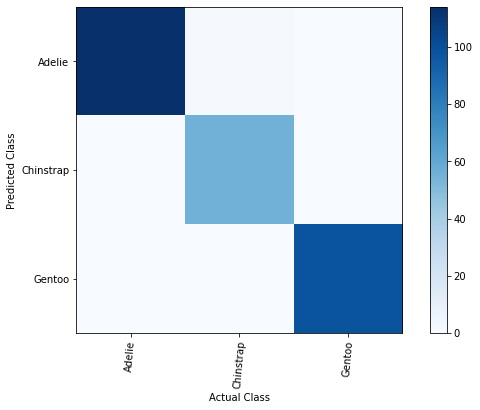

0.06108472217815261

In [11]:
# let's review the models performance

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.figure(figsize=(10,6))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# both the training loss AND the validation loss are reducing with each epoch. Good. This suggests that we're not
# overfitting our data, because the validation loss is continuously improving, and our model is continuously
# improving simultaneously. However, the validation accuracy is suspiciously high at 100% suggesting overfitting

import numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error

class_probabilities = model_norm.predict(X_test_norm)
predictions = np.argmax(class_probabilities, axis=1) # select highest probability for prediction
true_labels = np.argmax(y_test.values, axis=1) # select 

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=85)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

rmse_norm=np.sqrt(mean_squared_error(true_labels,predictions))
rmse_norm

In [ ]:
# so the model predicts Adelie most reliably. 

In [17]:
# let's now fit the model using the standardised data for comparison

# we'll create a separate NN so as not to conflate the models

model_stand = Sequential()
model_stand.add(Dense(hl, input_dim=num_features, activation='relu'))
model_stand.add(Dense(hl, input_dim=hl, activation='relu'))
model_stand.add(Dense(num_penguin_classes, input_dim=hl, activation='softmax'))

model_stand.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_stand.fit(X_train_scale, y_train, epochs=num_epochs, batch_size=10, validation_data=(X_test_scale, y_test))
prob = model_stand.predict(X_test_scale)
predictions = np.argmax(prob, axis=1) # select highest probability for prediction
true_labels = np.argmax(y_test.values, axis=1)

rmse_stand=np.sqrt(mean_squared_error(true_labels,predictions))
rmse_stand

Epoch 1/50
107/107 [==============================] - 0s 1ms/step - loss: 0.3571 - accuracy: 0.8596 - val_loss: 0.0675 - val_accuracy: 0.9925
Epoch 2/50
107/107 [==============================] - 0s 706us/step - loss: 0.0356 - accuracy: 0.9944 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 3/50
107/107 [==============================] - 0s 710us/step - loss: 0.0177 - accuracy: 0.9981 - val_loss: 0.0173 - val_accuracy: 0.9925
Epoch 4/50
107/107 [==============================] - 0s 696us/step - loss: 0.0133 - accuracy: 0.9953 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 5/50
107/107 [==============================] - 0s 705us/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 6/50
107/107 [==============================] - 0s 707us/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 7/50
107/107 [==============================] - 0s 704us/step - loss: 0.0083 - accuracy: 0.9991 - val_loss: 0.0076 - val_accuracy: 1

0.0

In [16]:
# and finally with the raw data for comparison

model_raw = Sequential()
model_raw.add(Dense(hl, input_dim=num_features, activation='relu'))
model_raw.add(Dense(hl, input_dim=hl, activation='relu'))
model_raw.add(Dense(num_penguin_classes, input_dim=hl, activation='softmax'))

model_raw.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_raw.fit(X_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(X_test, y_test))
prob = model_raw.predict(X_test)
predictions = np.argmax(prob, axis=1) # select highest probability for prediction
true_labels = np.argmax(y_test.values, axis=1)

rmse_raw=np.sqrt(mean_squared_error(true_labels,predictions))
rmse_raw

Epoch 1/50
107/107 [==============================] - 0s 2ms/step - loss: 94.1122 - accuracy: 0.3764 - val_loss: 4.6981 - val_accuracy: 0.6455
Epoch 2/50
107/107 [==============================] - 0s 695us/step - loss: 4.6486 - accuracy: 0.4803 - val_loss: 3.3593 - val_accuracy: 0.3097
Epoch 3/50
107/107 [==============================] - 0s 687us/step - loss: 3.9645 - accuracy: 0.4831 - val_loss: 3.9061 - val_accuracy: 0.2127
Epoch 4/50
107/107 [==============================] - 0s 689us/step - loss: 4.2681 - accuracy: 0.4644 - val_loss: 2.5273 - val_accuracy: 0.2687
Epoch 5/50
107/107 [==============================] - 0s 689us/step - loss: 3.6232 - accuracy: 0.4869 - val_loss: 1.8846 - val_accuracy: 0.5224
Epoch 6/50
107/107 [==============================] - 0s 696us/step - loss: 3.1868 - accuracy: 0.4888 - val_loss: 1.6151 - val_accuracy: 0.6157
Epoch 7/50
107/107 [==============================] - 0s 690us/step - loss: 2.9216 - accuracy: 0.4831 - val_loss: 2.8619 - val_accuracy: 

0.3814739677352853

In [18]:
# visualizing the result    
scale_compare = pd.DataFrame({'RMSE':[rmse_raw,rmse_norm,rmse_stand]},index=['Unscaled','Normalised','Standardised'])
scale_compare

,RMSE
Unscaled,0.381474
Normalised,0.061085
Standardised,0.000000


In [ ]:
# interesting. The standardised scaling work best, although with a suspiciously high accuracy (need to look into this)
# this was contrary to our initial expectations that the normalised scaling would work best for non-Gaussian
# feature distributions. Nevertheless, scaling clearly works and is an important step in pre-processing data.